In [10]:
from torchvision import transforms, models
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set the environment variable
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Global variable
MAX_SIZE = 400

load vgg19 features
Freeze all pamameters in vgg and only optimizing the target image

In [11]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

c:\Users\Snowball\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Snowball\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


select between cuda, mps and cpu

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

load image & convert tensor to image

In [13]:
def load_image(img_path, max_size=MAX_SIZE, shape=None):

    image = Image.open(img_path)
    if shape:
        image.resize(shape)
    image.convert('RGB')

    size = min(max_size, max(image.size))

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image


def im_convert(tensor):
    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

Gram Matrix

In [14]:
def gram_matrix(tensor):
    _, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)
    # Compute the Gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram


Get Features

In [15]:
def get_features(image, model, target_layers=['0', '5', '10', '19', '21', '28']):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in target_layers:
            features[name] = x
    return features

Start Proecess

In [16]:
# load in content and style image
content = load_image('images/rainier.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/autumn-oak.jpg', shape=content.shape[-2:]).to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {name:gram_matrix(style_features[name]) for name in style_features}

target = content.clone().requires_grad_(True).to(device)

Weights for styles

In [17]:
style_weights = {'0':0.2, '5':0.2, '10':0.2, '19':0.2, '21':0, '28':0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

Part1 Start process proposed by Gatys

In [18]:
# for displaying the target image, intermittently
import tqdm


show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 8000  # decide how many iterations to update your image (5000)

for ii in tqdm.tqdm(range(1, steps+1)):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['21'] - content_features['21'])**2)
    
    style_loss = 0
    
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())

  5%|▌         | 409/8000 [00:08<02:42, 46.86it/s]

Total loss:  59810292.0


 10%|█         | 808/8000 [00:16<02:30, 47.89it/s]

Total loss:  34415688.0


 15%|█▌        | 1205/8000 [00:24<02:16, 49.65it/s]

Total loss:  24686180.0


 20%|██        | 1608/8000 [00:32<01:55, 55.25it/s]

Total loss:  18919834.0


 25%|██▌       | 2005/8000 [00:40<02:06, 47.56it/s]

Total loss:  14816900.0


 30%|███       | 2408/8000 [00:49<02:04, 45.08it/s]

Total loss:  11634258.0


 35%|███▌      | 2806/8000 [00:57<01:43, 50.00it/s]

Total loss:  9055987.0


 40%|████      | 3209/8000 [01:06<01:41, 47.03it/s]

Total loss:  6947916.0


 45%|████▌     | 3608/8000 [01:14<01:19, 55.16it/s]

Total loss:  5265060.0


 50%|█████     | 4005/8000 [01:23<01:24, 47.32it/s]

Total loss:  3963572.0


 55%|█████▌    | 4407/8000 [01:39<01:16, 47.26it/s]

Total loss:  2988008.0


 60%|██████    | 4803/8000 [01:49<01:22, 38.91it/s]

Total loss:  2269484.25


 65%|██████▌   | 5205/8000 [02:00<01:02, 45.02it/s]

Total loss:  1738308.875


 70%|███████   | 5604/8000 [02:11<01:05, 36.80it/s]

Total loss:  1339784.5


 75%|███████▌  | 6006/8000 [02:23<00:54, 36.68it/s]

Total loss:  1035966.4375


 80%|████████  | 6405/8000 [02:33<00:39, 40.60it/s]

Total loss:  803167.6875


 85%|████████▌ | 6805/8000 [02:45<00:28, 41.24it/s]

Total loss:  624120.875


 90%|█████████ | 7204/8000 [02:56<00:20, 38.01it/s]

Total loss:  487408.28125


 95%|█████████▌| 7608/8000 [03:07<00:08, 46.52it/s]

Total loss:  384557.78125


100%|██████████| 8000/8000 [03:20<00:00, 39.89it/s]

Total loss:  308569.25


Final result

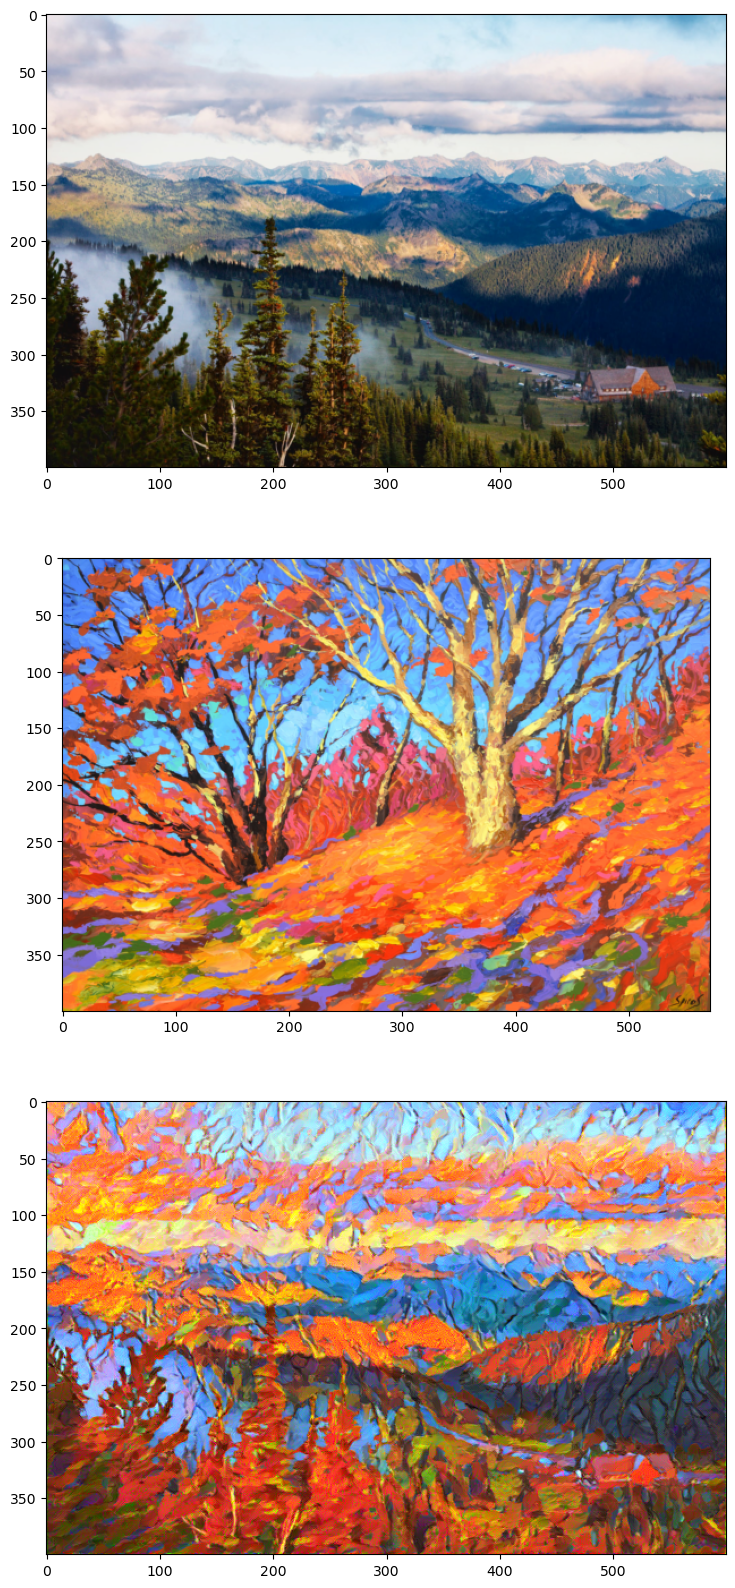

In [19]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 20))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))